In [165]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

Acquired zillow data using acquire.py (sequel query in this file)

In [166]:
# df = acquire.get_zillow_data()
# df.head()

In [167]:
df = pd.read_csv("zillow_dataframe.csv")

In [168]:
df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [169]:
df.shape

(52169, 15)

In [170]:
# df = prepare.handle_missing_values(df)

In [171]:
df.isnull().sum()

tax_rate                            5
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet        8
fips                                0
garagecarcnt                    34203
latitude                            0
longitude                           0
lotsizesquarefeet                 354
poolcnt                         41105
taxvaluedollarcnt                   1
yearbuilt                          40
landtaxvaluedollarcnt               1
logerror                            0
county_name                         0
dtype: int64

### Add new features for modeling:
- Scale latitude and longitude by hand
- price_per_sq_ft (value of house / house square footage
- land_price_per_sq_ft  (land tax value / lot square footage)

In [172]:
df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

In [173]:
df['price_per_sq_ft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df['lot_price_per_sq_ft'] = df['landtaxvaluedollarcnt'] / df['lotsizesquarefeet']

In [174]:
df.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,33.63,-117.87,"4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange,330.09,119.30
1,0.01,1.00,2.00,"1,465.00","6,111.00",1.00,34.45,-119.28,"12,647.00",nan,"464,000.00","1,967.00","376,000.00",0.06,Ventura,316.72,29.73
2,0.01,2.00,3.00,"1,243.00","6,059.00",2.00,33.89,-117.82,"8,432.00",1.00,"564,778.00","1,962.00","479,489.00",0.01,Orange,454.37,56.87
3,0.01,3.00,4.00,"2,376.00","6,037.00",nan,34.25,-118.24,"13,038.00",1.00,"145,143.00","1,970.00","36,225.00",-0.10,Los Angeles,61.09,2.78
4,0.01,3.00,4.00,"2,962.00","6,037.00",nan,34.15,-118.18,"63,000.00",1.00,"773,303.00","1,950.00","496,619.00",-0.00,Los Angeles,261.07,7.88


****** move this drop columns code to after the exploration phase ******

In [175]:
# df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

### Split the data into train and test, 70/30

In [176]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [177]:
train.shape

(36518, 17)

In [178]:
test.shape

(15651, 17)

### Proof of Concept - Clustering fips (aka binning the 3 different counties)

In [179]:
# def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
#     kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
#     kmeans.fit(train[[cluster_cols]])
#     cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
#     train[cluster_feature] = kmeans.predict(train[[cluster_cols]])
#     test[cluster_feature] = kmeans.predict(test[[cluster_cols]])
#     return train, test, kmeans

In [180]:
# train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = 'fips', k=3)

In [181]:
# train, test, kmeans = fips_cluster(train, test, columns='fips', n=3)

In [182]:
kmeans = KMeans(n_clusters=3, n_init=1, max_iter=100, random_state=123)

In [183]:
kmeans.fit(train[['fips']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [184]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06


In [185]:
cluster = 'cluster_' + str('fips')

train[cluster] = kmeans.predict(train[['fips']])

test[cluster] = kmeans.predict(test[['fips']])

In [186]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76,0
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50,1
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09,0
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78,1
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06,1


In [187]:
test.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
10408,0.03,2.00,3.00,"1,064.00","6,037.00",nan,34.58,-118.06,"7,046.00",nan,"65,261.00","1,956.00","27,191.00",-0.02,Los Angeles,61.34,3.86,1
38980,0.01,3.00,5.00,"2,486.00","6,037.00",nan,34.17,-118.45,"6,889.00",nan,"700,760.00","1,947.00","432,253.00",0.05,Los Angeles,281.88,62.75,1
34986,0.01,2.50,3.00,"2,478.00","6,059.00",2.00,33.62,-117.65,"6,745.00",1.00,"347,952.00","1,975.00","144,512.00",0.19,Orange,140.42,21.43,0
28445,0.01,2.50,4.00,"2,326.00","6,059.00",2.00,33.53,-117.67,"3,407.00",nan,"433,964.00","2,000.00","210,977.00",0.04,Orange,186.57,61.92,0
48292,0.01,2.00,4.00,"2,147.00","6,059.00",1.00,33.81,-117.98,"11,700.00",nan,"466,024.00","1,956.00","331,294.00",0.03,Orange,217.06,28.32,0


In [188]:
# X1 = train[['fips']]
# X2 = test[['fips']]

In [189]:
# X1 = train[['fips']]
# X2 = test[['fips']]

# kmeans = KMeans(n_clusters=3, random_state=123, n_init=1, max_iter=100)
# kmeans.fit(X1)

# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)
                                         
# PREDICT ON X_train and predict on X_test for other clustering

In [190]:
# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)

In [191]:
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)

In [192]:
# train_cluster_fips.isnull().sum()

In [193]:
# train['cluster'] = pd.Series(kmeans.predict(X1)).astype(str)
# test['cluster'] = pd.Series(kmeans.predict(X2)).astype(str)

In [194]:
# train_cluster_fips.isnull().sum()

Elbow method to determine how many clusters are necessary

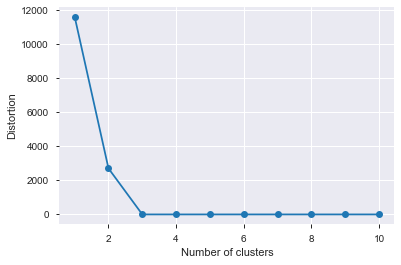

In [195]:
X1 = train[['cluster_fips']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X1)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [196]:
# KMeans.predict?

## Clustering based on price per square foot, latitude, and longitude

In [197]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76,0
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50,1
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09,0
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78,1
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06,1


In [198]:
kmeans = KMeans(n_clusters=10, n_init=1, max_iter=100, random_state=123)

In [199]:
train.price_per_sq_ft = train.price_per_sq_ft.isnull().dropna()

In [200]:
test.price_per_sq_ft = test.price_per_sq_ft.isnull().dropna()

In [201]:
train.price_per_sq_ft.isnull().sum()

0

In [202]:
kmeans.fit(train[['price_per_sq_ft', 'latitude', 'longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [203]:
cluster = 'cluster_' + str('sqft')

train[cluster] = kmeans.predict(train[['price_per_sq_ft', 'latitude', 'longitude']])

test[cluster] = kmeans.predict(test[['price_per_sq_ft', 'latitude', 'longitude']])

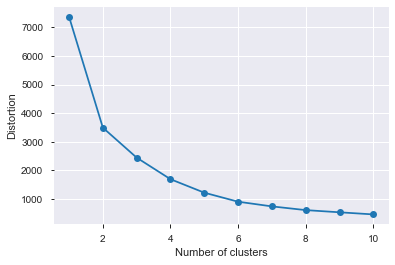

In [204]:
X2 = train[['price_per_sq_ft', 'latitude', 'longitude']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X2)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Encode clusters

In [205]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_sqft
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,False,14.76,0,8
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,False,1.50,1,1
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,False,64.09,0,0
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,False,52.78,1,9
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,False,62.06,1,7


In [206]:
test.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_sqft
10408,0.03,2.00,3.00,"1,064.00","6,037.00",nan,34.58,-118.06,"7,046.00",nan,"65,261.00","1,956.00","27,191.00",-0.02,Los Angeles,False,3.86,1,4
38980,0.01,3.00,5.00,"2,486.00","6,037.00",nan,34.17,-118.45,"6,889.00",nan,"700,760.00","1,947.00","432,253.00",0.05,Los Angeles,False,62.75,1,7
34986,0.01,2.50,3.00,"2,478.00","6,059.00",2.00,33.62,-117.65,"6,745.00",1.00,"347,952.00","1,975.00","144,512.00",0.19,Orange,False,21.43,0,0
28445,0.01,2.50,4.00,"2,326.00","6,059.00",2.00,33.53,-117.67,"3,407.00",nan,"433,964.00","2,000.00","210,977.00",0.04,Orange,False,61.92,0,0
48292,0.01,2.00,4.00,"2,147.00","6,059.00",1.00,33.81,-117.98,"11,700.00",nan,"466,024.00","1,956.00","331,294.00",0.03,Orange,False,28.32,0,8


In [207]:
train_cluster_fips = train.drop(columns='cluster_sqft')
test_cluster_fips = test.drop(columns='cluster_sqft')

In [208]:
train_cluster_sqft = train.drop(columns='cluster_fips')
test_cluster_sqft = test.drop(columns='cluster_fips')

In [209]:
train_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,False,14.76,0
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,False,1.50,1
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,False,64.09,0
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,False,52.78,1
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,False,62.06,1


In [210]:
test_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
10408,0.03,2.00,3.00,"1,064.00","6,037.00",nan,34.58,-118.06,"7,046.00",nan,"65,261.00","1,956.00","27,191.00",-0.02,Los Angeles,False,3.86,1
38980,0.01,3.00,5.00,"2,486.00","6,037.00",nan,34.17,-118.45,"6,889.00",nan,"700,760.00","1,947.00","432,253.00",0.05,Los Angeles,False,62.75,1
34986,0.01,2.50,3.00,"2,478.00","6,059.00",2.00,33.62,-117.65,"6,745.00",1.00,"347,952.00","1,975.00","144,512.00",0.19,Orange,False,21.43,0
28445,0.01,2.50,4.00,"2,326.00","6,059.00",2.00,33.53,-117.67,"3,407.00",nan,"433,964.00","2,000.00","210,977.00",0.04,Orange,False,61.92,0
48292,0.01,2.00,4.00,"2,147.00","6,059.00",1.00,33.81,-117.98,"11,700.00",nan,"466,024.00","1,956.00","331,294.00",0.03,Orange,False,28.32,0


In [211]:
train_cluster_fips, test_cluster_fips, ohe1 = prepare.encode(train_cluster_fips, test_cluster_fips, 'cluster_fips')

In [212]:
train_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_fips_0,cluster_fips_1,cluster_fips_2
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,...,"1,955.00","88,553.00",-0.08,Orange,False,14.76,0,1.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,...,"1,957.00","16,333.00",-0.04,Los Angeles,False,1.50,1,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,"1,998.00","576,786.00",0.03,Orange,False,64.09,0,1.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,...,"2,003.00","330,000.00",0.07,Los Angeles,False,52.78,1,0.00,1.00,0.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,...,"1,974.00","437,002.00",0.08,Los Angeles,False,62.06,1,0.00,1.00,0.00


In [213]:
test_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_fips_0,cluster_fips_1,cluster_fips_2
10408,0.03,2.00,3.00,"1,064.00","6,037.00",nan,34.58,-118.06,"7,046.00",nan,...,"1,956.00","27,191.00",-0.02,Los Angeles,False,3.86,1,0.00,1.00,0.00
38980,0.01,3.00,5.00,"2,486.00","6,037.00",nan,34.17,-118.45,"6,889.00",nan,...,"1,947.00","432,253.00",0.05,Los Angeles,False,62.75,1,0.00,1.00,0.00
34986,0.01,2.50,3.00,"2,478.00","6,059.00",2.00,33.62,-117.65,"6,745.00",1.00,...,"1,975.00","144,512.00",0.19,Orange,False,21.43,0,1.00,0.00,0.00
28445,0.01,2.50,4.00,"2,326.00","6,059.00",2.00,33.53,-117.67,"3,407.00",nan,...,"2,000.00","210,977.00",0.04,Orange,False,61.92,0,1.00,0.00,0.00
48292,0.01,2.00,4.00,"2,147.00","6,059.00",1.00,33.81,-117.98,"11,700.00",nan,...,"1,956.00","331,294.00",0.03,Orange,False,28.32,0,1.00,0.00,0.00


In [214]:
train_cluster_sqft, test_cluster_sqft, ohe2 = prepare.encode(train_cluster_sqft, test_cluster_sqft, 'cluster_sqft')

In [215]:
test_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
10408,0.03,2.00,3.00,"1,064.00","6,037.00",nan,34.58,-118.06,"7,046.00",nan,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
38980,0.01,3.00,5.00,"2,486.00","6,037.00",nan,34.17,-118.45,"6,889.00",nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
34986,0.01,2.50,3.00,"2,478.00","6,059.00",2.00,33.62,-117.65,"6,745.00",1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
28445,0.01,2.50,4.00,"2,326.00","6,059.00",2.00,33.53,-117.67,"3,407.00",nan,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48292,0.01,2.00,4.00,"2,147.00","6,059.00",1.00,33.81,-117.98,"11,700.00",nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


### Inverse transform clusters to prove which county belongs to which cluster

In [104]:
# ohe1.inverse_transform(df[['0', '1', '2']])

### Drop cluster column and rename clusters as county names

In [216]:
train_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_fips_0,cluster_fips_1,cluster_fips_2
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,...,"1,955.00","88,553.00",-0.08,Orange,False,14.76,0,1.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,...,"1,957.00","16,333.00",-0.04,Los Angeles,False,1.50,1,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,"1,998.00","576,786.00",0.03,Orange,False,64.09,0,1.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,...,"2,003.00","330,000.00",0.07,Los Angeles,False,52.78,1,0.00,1.00,0.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,...,"1,974.00","437,002.00",0.08,Los Angeles,False,62.06,1,0.00,1.00,0.00


In [217]:
train_cluster_fips = train_cluster_fips.drop(columns='cluster_fips')

train_cluster_fips['los_angeles'] = train_cluster_fips['cluster_fips_0']
train_cluster_fips['ventura'] = train_cluster_fips['cluster_fips_1']
train_cluster_fips['orange'] = train_cluster_fips['cluster_fips_2']

train_cluster_fips = train_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

In [218]:
test_cluster_fips = test_cluster_fips.drop(columns='cluster_fips')

test_cluster_fips['los_angeles'] = test_cluster_fips['cluster_fips_0']
test_cluster_fips['ventura'] = test_cluster_fips['cluster_fips_1']
test_cluster_fips['orange'] = test_cluster_fips['cluster_fips_2']

test_cluster_fips = test_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

In [219]:
train.shape

(36518, 19)

In [220]:
test.shape

(15651, 19)

### Impute "poolcnt", "garagecarcnt" with 0s using a function. (reference prepare.py)

 - Run this on train and test subsets separately

In [221]:
cols = ["poolcnt", "garagecarcnt"]

In [222]:
# Impute zeros into poolcnt and garagecarcnt on train set

train = prepare.fill_zero(train, cols=cols)

In [223]:
# Impute zeros into poolcnt and garagecarcnt on test set

test = prepare.fill_zero(test, cols=cols)

### Drop columns then rows using function (reference prepare.py)

 - Run this on train and test subsets separately

In [224]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

train = prepare.handle_missing_values(train)

In [225]:
# drop columns that have more than 50% of values missing and rows with more than 75% of values missing

test = prepare.handle_missing_values(test)

### Drop the remaining Nulls in df to get clean train and test data sets

In [226]:
train.dropna(inplace=True)

In [227]:
test.dropna(inplace=True)

### The train and test subsets with no missing values and poolcnt and garagecarcnt imputed with zeros. Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with outliers handled, see below...

In [228]:
train.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
price_per_sq_ft                 0
lot_price_per_sq_ft             0
cluster_fips                    0
cluster_sqft                    0
dtype: int64

In [229]:
test.isnull().sum()

tax_rate                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
taxvaluedollarcnt               0
yearbuilt                       0
landtaxvaluedollarcnt           0
logerror                        0
county_name                     0
price_per_sq_ft                 0
lot_price_per_sq_ft             0
cluster_fips                    0
cluster_sqft                    0
dtype: int64

In [230]:
train.bedroomcnt.value_counts()

 3.00    16310
 4.00    10614
 2.00     5838
 5.00     2760
 6.00      451
 1.00      440
 7.00       75
 8.00       20
 9.00        6
10.00        2
14.00        1
12.00        1
Name: bedroomcnt, dtype: int64

In [231]:
train.bathroomcnt.value_counts()

 2.00    15260
 3.00     7474
 1.00     6627
 2.50     2804
 4.00     1571
 3.50      630
 1.50      578
 5.00      542
 4.50      482
 6.00      224
 5.50      160
 7.00       57
 8.00       40
 6.50       35
 7.50       14
 9.00       11
10.00        3
 8.50        2
11.00        2
18.00        1
13.00        1
Name: bathroomcnt, dtype: int64

Zillow's log error was low on the los angeles high priced outlier.  LA county houses seems to have the highest log error outliers

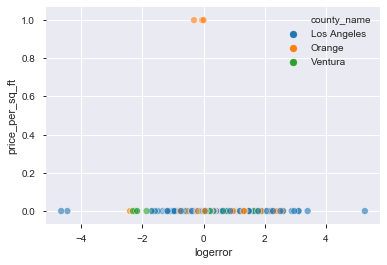

In [232]:
sns.scatterplot(data=train, x="logerror", y="price_per_sq_ft", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

Before outliers

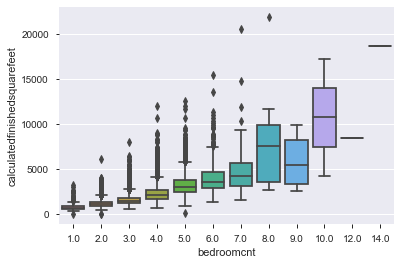

In [233]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

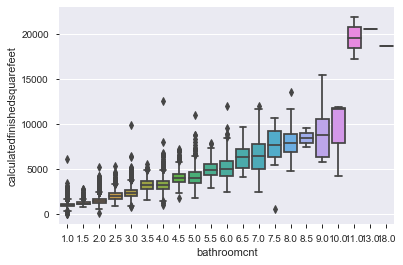

In [234]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

### Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [ ]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
train.shape

In [ ]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt", "lotsizesquarefeet"], k=1.5)
test.shape

### Convert dtypes to category for the cols below

- train_cat and test_cat are subsets with dtypes converted to category for the following columns:

    - "bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"
    
- train_cat and test_cat also have outliers handled and no missing values.

In [ ]:
train.info()

In [ ]:
cols = ["bathroomcnt", "bedroomcnt", "poolcnt", "yearbuilt", "garagecarcnt", "county_name"]

In [ ]:
train_cat = prepare.numeric_to_category(train, cols)

In [ ]:
test_cat = prepare.numeric_to_category(test, cols)

In [ ]:
train_cat.info()

In [ ]:
train.bedroomcnt.value_counts()

In [ ]:
train.bathroomcnt.value_counts()

In [ ]:
sns.scatterplot(data=train, x="logerror", y="taxvaluedollarcnt", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

In [ ]:
sns.scatterplot(data=train, x="logerror", y="price_per_sq_ft", hue="county_name", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

In [ ]:
sns.boxplot(train.bedroomcnt, train.calculatedfinishedsquarefeet)

In [ ]:
sns.boxplot(train.bathroomcnt, train.calculatedfinishedsquarefeet)

## Bin yearbuilt by Decade

- 1878 - 2015

- Drop 11 rows with yearbuilt == 0.00

In [ ]:
sns.scatterplot(data=train_cat, x="yearbuilt", y="price_per_sq_ft")

In [ ]:
sns.scatterplot(data=train_cat, x="price_per_sq_ft", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="yearbuilt", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="lot_price_per_sq_ft", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="latitude", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="longitude", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="garagecarcnt", y="logerror")

In [ ]:
sns.scatterplot(data=train_cat, x="bedroomcnt", y="logerror")

### Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [ ]:
# contingency_table from the df_cat dataframe (w/o categories)

contingency_table = pd.crosstab(train_cat.bedroomcnt, train_cat.bathroomcnt)
contingency_table

In [ ]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [ ]:
print(f"The p-value of the contingency test is {p}.")

### Takeaways from chi2 test on bedroomcnt and bathroomcnt

- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [ ]:
contingency_table = pd.crosstab(train_cat.garagecarcnt, train_cat.poolcnt)
contingency_table

In [ ]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [ ]:
print(f"The p-value of the contingency test is {p}.")

In [ ]:
r, p = stats.pearsonr(train_cat.lotsizesquarefeet, train_cat.taxvaluedollarcnt)

In [ ]:
print(f"r is {r}")

In [ ]:
print(f"p is {p}")

In [ ]:
# creating df handling values above 10_000 sqfeet to get a better look at the relationship between the variables

lot_no_outliers = train_cat[train_cat.lotsizesquarefeet > 10000]

### DB Scan this thingy

In [ ]:
sns.jointplot(data=lot_no_outliers, y="taxvaluedollarcnt", x="lotsizesquarefeet")

## Split train and test into X_train, X_test, y_train, y_test

In [236]:
train_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,los_angeles,ventura,orange
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,False,14.76,1.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,False,1.50,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,False,64.09,1.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,False,52.78,0.00,1.00,0.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,False,62.06,0.00,1.00,0.00


In [237]:
train_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [ ]:
train = train.drop(columns='county_name')
test = test.drop(columns='county_name')

In [ ]:
df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'yearbuilt'])

In [ ]:
X_train = train.drop(columns="logerror")

y_train = train[["logerror"]]

X_test = test.drop(columns="logerror")

y_test = test[["logerror"]]

## Model - Linear Regression Model

In [ ]:
X_train.dtypes

In [ ]:
X_train.head()

In [ ]:
X_train.garagecarcnt = X_train.garagecarcnt.astype(float)
X_train.bathroomcnt = X_train.bathroomcnt.astype(float)
X_train.bedroomcnt = X_train.bedroomcnt.astype(float)
X_train.poolcnt = X_train.poolcnt.astype(float)

In [ ]:
X_train = X_train.drop(columns='yearbuilt')
X_test = X_test.drop(columns='yearbuilt')

In [ ]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

In [ ]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [ ]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
type(yhat)
yhat

In [ ]:
actual = y_train
actual.head()

In [ ]:
actual['yhat'] = yhat

### Evaluate LR Model

In [ ]:
actual["residual"] = actual["yhat"] - actual["logerror"]

In [ ]:
sns.distplot(actual["residual"])

In [ ]:
sns.scatterplot(actual["logerror"], actual["yhat"])

In [ ]:
actual["residual^2"] = actual["residual"] ** 2

In [ ]:
sse = sum(actual["residual^2"])
print(f"sse = {sse}")
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

In [ ]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

- Create a numpy array from the y_df_nums_train df, so I can run eval metrics using yhat(prediction array) and y_array (array of actual y values)

In [ ]:
y_array = np.array(y_train)
type(y_array)

In [ ]:
r2_score(actual.logerror, actual.yhat)

In [ ]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

### Takeaways from the Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

### Model - K Neighbors Regressor

In [ ]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [ ]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

In [ ]:
yhat = neigh.predict(X_train)
type(yhat)

In [ ]:
r2 = neigh.score(X_train, y_train)

In [ ]:
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

### Takeaways from KNRegressor Model

- This model explained more than 50% more of the variance in logerror than my LR model using exactly the same data.

- The subset of data I used was comprised of the numeric values only from the original dataframe.

- I think this model could do even better with outliers handled and some feature engineering.

### Model df - Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
rf = RandomForestRegressor(n_estimators=10)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

In [ ]:
y_pred = rf.predict(X_test)
print(f'root mean squared error = {mean_squared_error(y_test, y_pred)**1/2}')

### PUT TAKEAWAYS FROM RANDOM FOREST MODEL HERE

In [ ]:
X_test.count()

In [ ]:
predictions_vs_actual = pd.DataFrame({'predictions_log_error': y_pred, 'actual_log_error': y_test.logerror, })

In [ ]:
predictions_vs_actual['fips'] = X_test.fips

In [ ]:
predictions_vs_actual.dtypes

In [ ]:
sns.scatterplot(data=predictions_vs_actual, x='predictions_log_error', y='actual_log_error', hue='fips')

#### FIX THIS COLORING BY REFERENCING WARMUP EXERCISE 11-08.  It thinks fips is continuous data so gives it a color gradient, not different colors